In [76]:
import praw
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import networkx as nx
from itertools import combinations
import community.community_louvain as community_louvain
from textblob import TextBlob
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import seaborn as sns

# Credenciais:
reddit = praw.Reddit(
    client_id='Tsap1dcFuTp8q-iaykEI4g',
    client_secret='hQMfXxt3LhQE0CGJm7jwCRAxgIXE6A',
    user_agent="kdd-data-collector by /u/Fun-Buy-3443"
)
subreddit = reddit.subreddit("helldivers")

In [77]:
posts = []
for post in subreddit.hot(limit=1000):
    posts.append({
        'title': post.title,
        'score': post.score,
        'num_comments': post.num_comments,
        'created_utc': datetime.fromtimestamp(post.created_utc, tz=timezone.utc)
    })

df = pd.DataFrame(posts)
df.to_csv('helldivers_posts.csv', index=False)

In [78]:
comments_data = []

for post in subreddit.hot(limit=50):
    post.comments.replace_more(limit=0)
    for comment in post.comments.list():
        comments_data.append({
            'post_id': post.id,
            'comment_id': comment.id,
            'author': str(comment.author),
            'parent_id': comment.parent_id,
            'body': comment.body,
            'score': comment.score,
            'created_utc': comment.created_utc
        })

df_comments = pd.DataFrame(comments_data)
df_comments.to_csv('helldivers_comments.csv', index=False)

In [79]:
nltk.download('stopwords')

# Crie uma lista única de stopwords
custom_stopwords = set(stopwords.words('english'))
custom_stopwords.update(['get', 'got', 'game', 'play', 'new', 'one', 'like', 'think', 'please', 'love', 'anyone', 
                         'know', 'something', 'help', 'want', 'also', 'see', 'time', 'good', 'bad', 'best', 'worst', 
                         'really', 'just', 'make', 'way', 'could', 'would', 'every', 'back', 'dont', 'getting'])  # Termos irrelevantes

def limpar_texto(text):
    if pd.isnull(text): return []
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in custom_stopwords and len(t) > 2]
    return tokens

all_tokens = []
for post in posts:
    tokens = limpar_texto(post['title'])
    all_tokens.extend(tokens)

# Conta palavras
contagem = Counter(all_tokens)
top_termos = contagem.most_common(15)

print("Palavras mais frequentes nos títulos:")
for palavra, freq in top_termos:
    print(f"{palavra}: {freq}")

Palavras mais frequentes nos títulos:
helldivers: 50
pack: 33
warp: 32
cape: 28
super: 28
warbond: 20
mission: 18
bug: 17
epoch: 16
earth: 16
armor: 15
guys: 14
illuminate: 14
war: 14
bot: 14


[nltk_data] Downloading package stopwords to /home/arthur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
G = nx.Graph()

for title in df['title']:
    tokens = limpar_texto(title)
    for w1, w2 in combinations(set(tokens), 2):
        if G.has_edge(w1, w2):
            G[w1][w2]['weight'] += 1
        else:
            G.add_edge(w1, w2, weight=1)

In [81]:
print("Número de palavras únicas:", G.number_of_nodes())
print("Número de pares de palavras (arestas):", G.number_of_edges())

# Palavras mais "centrais" (com maior grau)
graus = sorted(G.degree, key=lambda x: x[1], reverse=True)
print("\nPalavras mais conectadas:")
for palavra, grau in graus[:10]:
    print(f"{palavra}: {grau}")

Número de palavras únicas: 1978
Número de pares de palavras (arestas): 9484

Palavras mais conectadas:
helldivers: 239
super: 160
pack: 104
warp: 90
warbond: 89
mission: 87
stratagem: 80
earth: 75
concept: 65
guys: 64


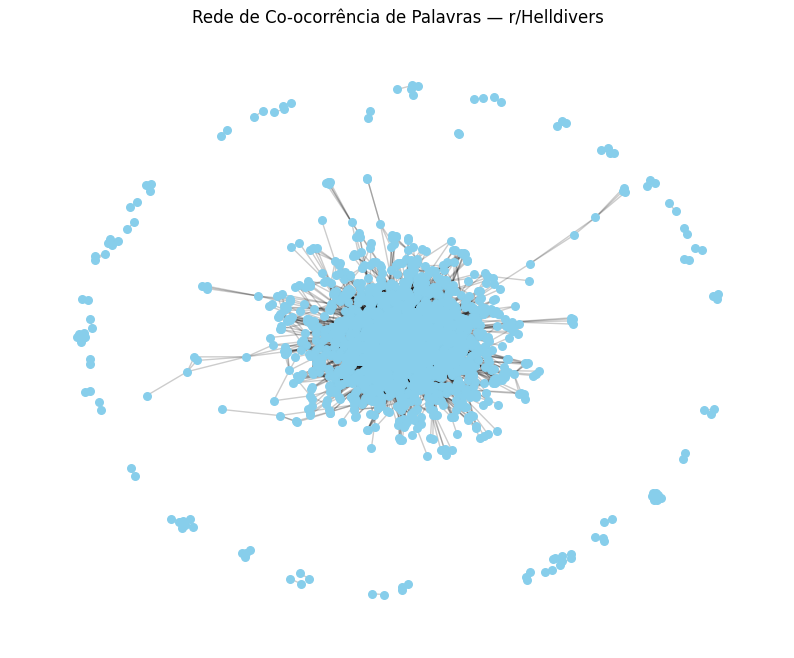

In [82]:

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)
top_nodes = dict(G.degree).keys()
nx.draw_networkx_nodes(G, pos, node_size=30, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Rede de Co-ocorrência de Palavras — r/Helldivers")
plt.axis('off')
plt.show()

In [83]:
G_users = nx.DiGraph()

for _, row in df_comments.iterrows():
    author = row['author']
    parent = row['parent_id']
    
    if parent.startswith("t1_"):  # t1 = comentário (t3 = post)
        parent_comment = df_comments[df_comments['comment_id'] == parent[3:]]
        if not parent_comment.empty:
            parent_author = parent_comment.iloc[0]['author']
            if author != parent_author and author != 'None' and parent_author != 'None':
                G_users.add_edge(author, parent_author)

In [84]:
partition = community_louvain.best_partition(G_users.to_undirected())

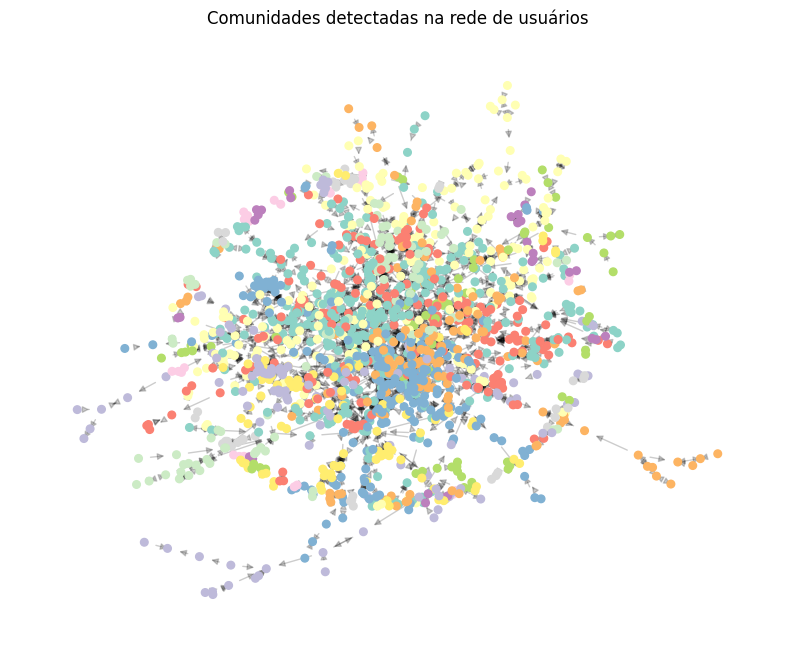

In [85]:
values = [partition.get(node) for node in G_users.nodes()]
pos = nx.spring_layout(G_users, seed=42)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G_users, pos, node_color=values, cmap=plt.cm.Set3, node_size=30)
nx.draw_networkx_edges(G_users, pos, alpha=0.2)
plt.title("Comunidades detectadas na rede de usuários")
plt.axis("off")
plt.show()

In [86]:
# Análise descritiva
print("Número de nós:", G.number_of_nodes())
print("Número de arestas:", G.number_of_edges())
print("Densidade:", nx.density(G))

Número de nós: 1978
Número de arestas: 9484
Densidade: 0.004850523180376146


In [87]:
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)
print("Número de comunidades:", len(communities))
centrality = nx.degree_centrality(G)
print("Top 5 centralidades:", sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5])

Número de comunidades: 74
Top 5 centralidades: [('helldivers', 0.12089023773394032), ('super', 0.08093070308548306), ('pack', 0.05260495700556399), ('warp', 0.045523520485584223), ('warbond', 0.04501770359129995)]


In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df['title'])

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

df['cluster'] = labels
print(df[['title', 'cluster']].head())

                                               title  cluster
0  Please share your feedback about Helldivers 2 ...        3
1                               New cape: Ingress-81        4
2  The Cover ears emote actually does protect you...        4
3                    Turret almost caught me lacking        4
4            I think I got dropped in thr wrong game        3


In [89]:
df['popular'] = (df['score'] > df['score'].median()).astype(int)
X = vectorizer.fit_transform(df['title'])
y = df['popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.54      0.60      0.56        99
           1       0.53      0.47      0.50        96

    accuracy                           0.53       195
   macro avg       0.53      0.53      0.53       195
weighted avg       0.53      0.53      0.53       195



In [90]:
df_comments['sentiment'] = df_comments['body'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
print(df_comments[['body', 'sentiment']].head())

                                                body  sentiment
0  Didn't buff stun/arc enough to compensate stat...   0.097238
1  Game is in poor state performance wise and pla...  -0.135714
2  i've never seen a company put out so many surv...   0.115330
3  Stop giving Illuminate MOs until they are a fi...  -0.305000
4  It's been soooo fucking buggy. Picking up weap...  -0.166667


In [91]:
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df['title'])

# Função para recomendar N posts semelhantes a um índice dado
def recomendar_posts(indice_post, n=5):
    similarities = cosine_similarity(tfidf_matrix[indice_post], tfidf_matrix).flatten()
    similar_indices = similarities.argsort()[::-1][1:n+1]
    return df.iloc[similar_indices][['title', 'score', 'cluster']]

# Exemplo: recomendações para o primeiro post
indice = 0
print("Post original:\n", df.iloc[indice]['title'], "\n")
print("Recomendações:\n")
print(recomendar_posts(indice))

Post original:
 Please share your feedback about Helldivers 2 in this survey! 

Recomendações:

                                                 title  score  cluster
749  What's your opinion about this well designed, ...   7523        2
656       Fix this before your SUMMER break thanks ~!!      1        2
833  A video about how to make a NCR ranger setup i...      2        3
237                           Post your best (please)!      1        4
584                    Sweet liberating pretty please?     13        4


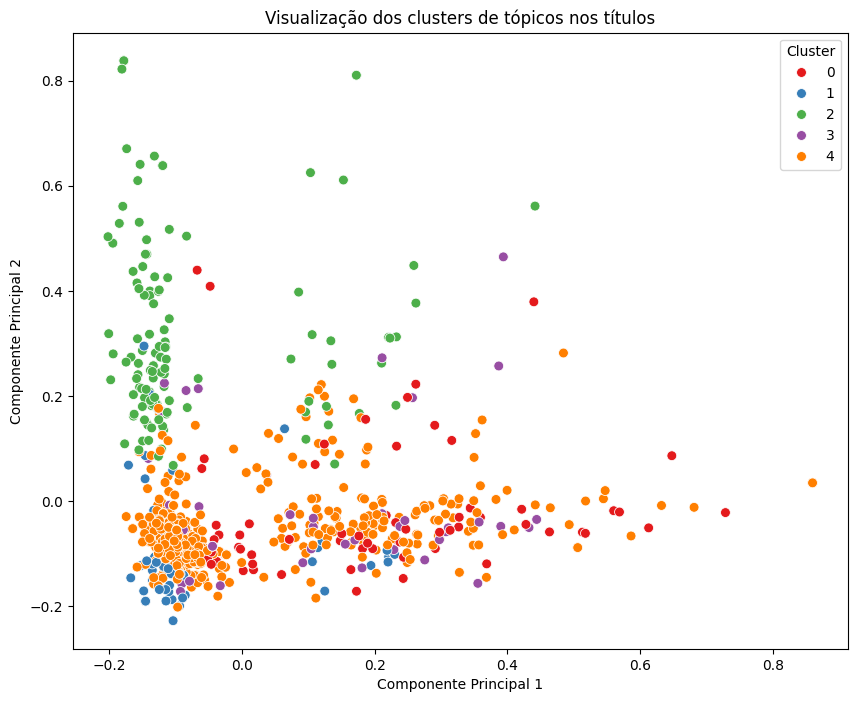

In [92]:
# Reduz para 2D com PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(tfidf_matrix.toarray())

# Plota os clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=df['cluster'], palette='Set1', s=50)
plt.title("Visualização dos clusters de tópicos nos títulos")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()

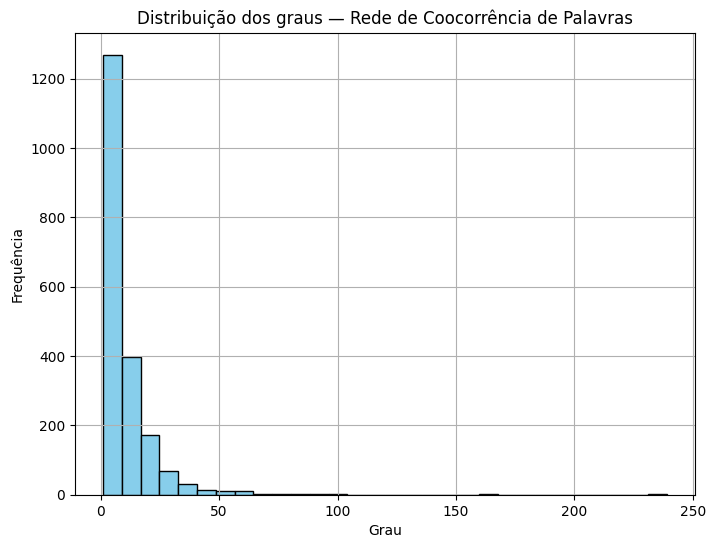

In [93]:
graus = [d for n, d in G.degree()]
plt.figure(figsize=(8, 6))
plt.hist(graus, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribuição dos graus — Rede de Coocorrência de Palavras")
plt.xlabel("Grau")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

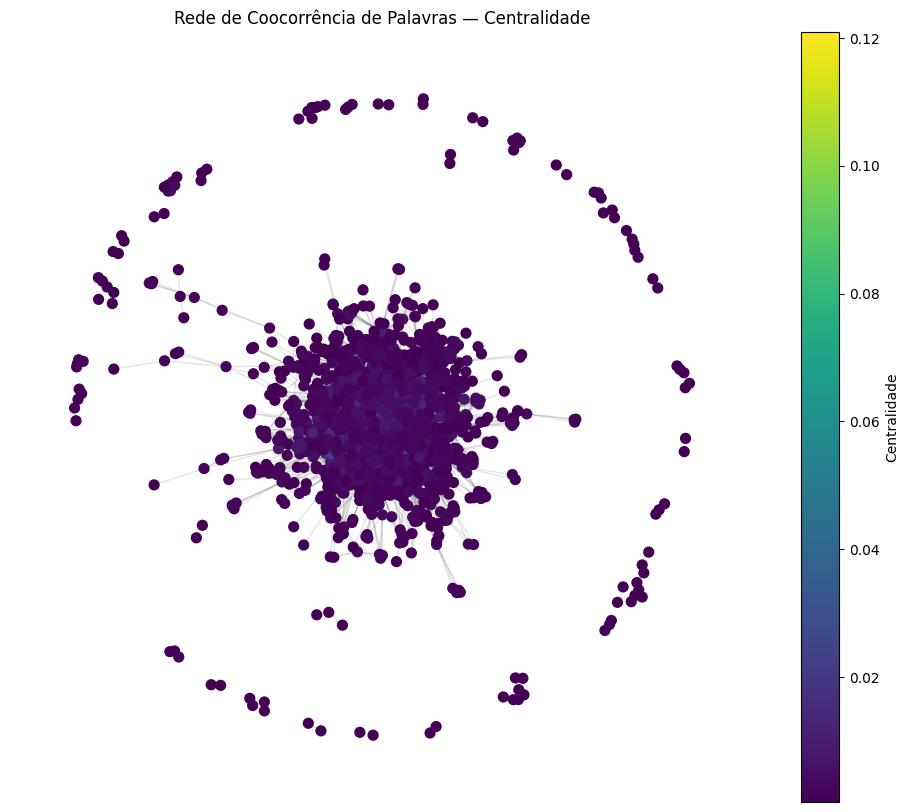

In [94]:
centralidade = nx.degree_centrality(G)
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.3, seed=42)

nodes = nx.draw_networkx_nodes(
    G, pos, node_size=50,
    node_color=list(centralidade.values()),
    cmap=plt.cm.viridis
)
edges = nx.draw_networkx_edges(G, pos, alpha=0.1)

plt.colorbar(nodes, label="Centralidade")
plt.title("Rede de Coocorrência de Palavras — Centralidade")
plt.axis("off")
plt.show()

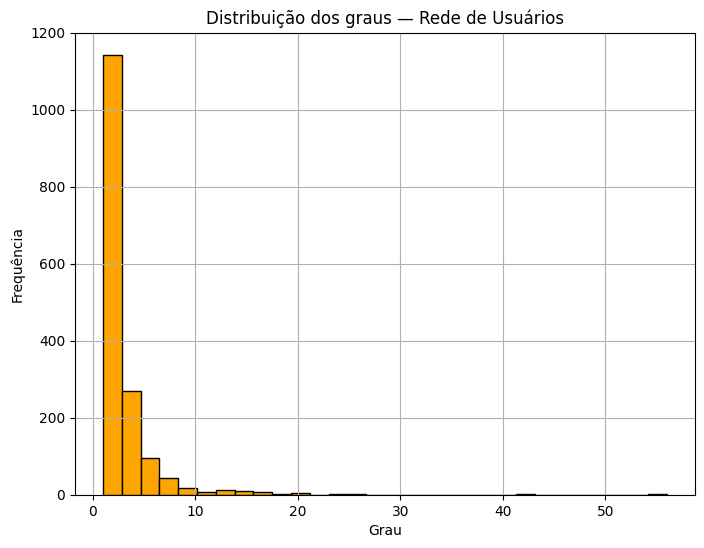

In [95]:
graus_usuarios = [d for n, d in G_users.degree()]
plt.figure(figsize=(8, 6))
plt.hist(graus_usuarios, bins=30, color='orange', edgecolor='black')
plt.title("Distribuição dos graus — Rede de Usuários")
plt.xlabel("Grau")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

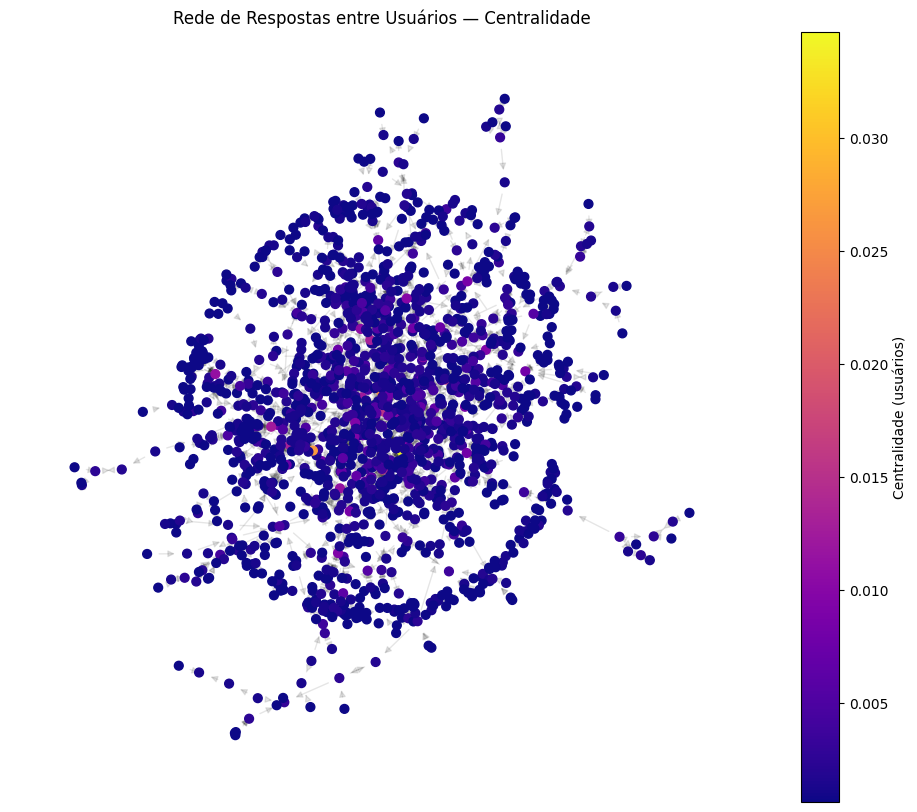

In [96]:
centralidade_usuarios = nx.degree_centrality(G_users)
pos = nx.spring_layout(G_users, seed=42, k=0.5)

plt.figure(figsize=(12, 10))
nodes = nx.draw_networkx_nodes(
    G_users, pos, node_size=40,
    node_color=list(centralidade_usuarios.values()),
    cmap=plt.cm.plasma
)
edges = nx.draw_networkx_edges(G_users, pos, alpha=0.1)

plt.colorbar(nodes, label="Centralidade (usuários)")
plt.title("Rede de Respostas entre Usuários — Centralidade")
plt.axis("off")
plt.show()

In [97]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Recria corpus limpo dos títulos
corpus = [' '.join(limpar_texto(t)) for t in df['title']]

# Usa CountVectorizer em vez de TF-IDF para LDA
vectorizer_lda = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_lda = vectorizer_lda.fit_transform(corpus)

In [98]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_lda)

,n_components,5
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [99]:
def mostrar_topicos(model, feature_names, n_palavras=10):
    for idx, topic in enumerate(model.components_):
        print(f"Tópico {idx+1}:")
        top_indices = topic.argsort()[:-n_palavras - 1:-1]
        print("  ", [feature_names[i] for i in top_indices])

mostrar_topicos(lda, vectorizer_lda.get_feature_names_out())

Tópico 1:
   ['illuminate', 'helldivers', 'epoch', 'super', 'feel', 'warbond', 'earth', 'say', 'pack', 'high']
Tópico 2:
   ['cape', 'armor', 'purple', 'super', 'bot', 'strider', 'ingress', 'crashing', 'experience', 'idea']
Tópico 3:
   ['helldivers', 'concept', 'thing', 'bug', 'war', 'solo', 'dog', 'super', 'whats', 'flag']
Tópico 4:
   ['pelican', 'stratagem', 'weapon', 'seaf', 'needs', 'hell', 'going', 'better', 'day', 'mission']
Tópico 5:
   ['warp', 'pack', 'helldivers', 'guys', 'kill', 'right', 'leviathans', 'democracy', 'helldiver', 'gaellivare']


In [100]:
topicos_por_post = lda.transform(X_lda)
df['lda_topic'] = topicos_por_post.argmax(axis=1)

print(df[['title', 'lda_topic']].head())

                                               title  lda_topic
0  Please share your feedback about Helldivers 2 ...          2
1                               New cape: Ingress-81          1
2  The Cover ears emote actually does protect you...          4
3                    Turret almost caught me lacking          0
4            I think I got dropped in thr wrong game          1
